<a href="https://colab.research.google.com/github/GeoMMpax/Ethics/blob/master/V6_E_E_sig_ANN_FairLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MetaData

Author Michael McCarthy mbmccart@utica.edu

Author Sundar Narayanan sundar.narayanan@aitechethics.com **bold text**

Copy of V2 on 02Nov2021

Copy of V3 on 16NOV2021

Changes include scaling data and getting dummies for categorical variables before splitting into Train/Test 

Copy of V4 on 29NOV2021

Changes include sigmoid in final layer for all models and updating the 
experiment so the activiation function was changed in the hidden layer.

Copy of V5

Added random seed control.  Reduced activations fucntions from all 9 to 5.
Softmax removed because it is for multi-class.
Sigmoid removed because it is for binary (already in final layer)

V6 
Stable. Experimental activation function "E" in both hidden layers.

## Google Drive File

In [ ]:
#https://pypi.org/project/PyDrive/
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
#authenticate users to have acces to google Drive.  Click the link to get the code.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Library Loading

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
#It is a function that renders the figure in a notebook (instead of displaying a dump of the figure object).
%matplotlib inline
# To remove the scientific notation from numpy arrays
#np.set_printoptions(suppress=True)

#Setting Seed for reproducable results (important to have tensorflow random seed set as well)
#https://datascience.stackexchange.com/questions/13314/causes-of-inconsistent-results-with-neural-network
np.random.seed(1)

# package for descriptive statistics
!pip install researchpy
import researchpy as rp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Get the file
#data from Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn Accessed 2021Sep20
##data wrangled outside this Python notebook. 
#Records with null for total charges removed
#"no internet service" and "no phone service" changed to "no"
# yes = 1 and no = 0
#gender female = 1 and male = 0
#customer ID removed
#recordID added
#stratified Sample 70/30 for based on "Gender" variable
#For Ver4 scaling data and getting dummies (i.e., one hot encoding) for categorical variables before splitting into Train/Test 
#New stratefied random split datafiles have "2" suffix

"""downloaded = drive.CreateFile({'id':'1se_OSf2TmEBerxcDUU5mwjS-55iN-csF'}) # replace the id with id of file you want to access
downloaded.GetContentFile('WA_Fn-UseC_-Telco-Customer-Churn_WrangleTrain2.csv') 
downloaded = drive.CreateFile({'id':'1wpB8kKSfqCEZXq0LUUlRVJFZ64vr6i0l'}) # replace the id with id of file you want to access
downloaded.GetContentFile('WA_Fn-UseC_-Telco-Customer-Churn_WrangleTEST2.csv') """

# second stratefied random sample for this dataset, has "dec" suffix
downloaded = drive.CreateFile({'id':'19hS4zGimbeFm2a1qMxyaDCuTLd1a0sLf'}) # replace the id with id of file you want to access
downloaded.GetContentFile('WA_Fn-UseC_-Telco-Customer-Churn_WrangleTrainDEC.csv') 
downloaded = drive.CreateFile({'id':'1CHhJIFG0vYPl5as6sXfCUT3Jeibw0dJa'}) # replace the id with id of file you want to access
downloaded.GetContentFile('WA_Fn-UseC_-Telco-Customer-Churn_WrangleTESTdec.csv') 

In [ ]:
## read the training file
#dfTrain = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn_WrangleTrain2.csv") # first stratified training dataset 
dfTrain = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn_WrangleTrainDEC.csv")  # second stratified training dataset 
print("Training Data: ",dfTrain.shape)
## read the TEST file
# dfTEST = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn_WrangleTEST2.csv") # first stratified testing dataset 
dfTEST = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn_WrangleTESTdec.csv")   # second stratified testing dataset 
del dfTrain['RecordID']  #"RecordID" included in dataset but removed because not variable in the analysis
del dfTEST['RecordID']   #"RecordID" included in dataset but removed because not variable in the analysis
print("Testing Data: ",dfTEST.shape)
## show a sample of n records
dfTrain.sample(10)
dfTEST.sample(10)
## show the top 5 for Train
print("\n Training Data \n")
print(dfTrain.head())
#Displace the varaible types for Train
print(dfTrain.dtypes)
print(dfTrain.shape)

## show the top 5 for Testing
print("\n Testing Data \n")
print(dfTEST.head())
#Displace the varaible types for Testing
print(dfTEST.dtypes)
print(dfTEST.shape)

Training Data:  (4922, 28)
Testing Data:  (2110, 27)

 Training Data 

   Churn  Dependents  DeviceProtection  MonthlyCharges  MultipleLines  \
0      1           0                 0        0.521891              0   
1      1           0                 1        0.809950              1   
2      0           0                 0        0.114428              0   
3      1           0                 1        0.861194              1   
4      0           1                 1        0.945274              1   

   OnlineBackup  OnlineSecurity  PaperlessBilling  Partner  PhoneService  ...  \
0             0               0                 1        0             1  ...   
1             0               0                 1        0             1  ...   
2             0               1                 0        0             0  ...   
3             0               0                 1        1             1  ...   
4             1               1                 0        1             1  ...   

   

In [ ]:
#install fairlearn
#if installing on a local IDE (e.g., Jupyter), do not use the exclamation point 
!pip install fairlearn
#install modeling packages
!pip install tensorflow

!pip install keras

     |████████████████████████████████| 177 kB 4.4 MB/s 
     |████████████████████████████████| 462 kB 3.8 MB/s 


## Data File Wrangle

In [ ]:
# Separate Target Variable and Predictor Variables
# define variable to class: Churn
#"Churn" is a dictomous variable used to identify customers who stop using the company's services
TargetVariable=["Churn"]
#it is VERY important that the list of variables matches the left to right order in the CSVs!
PredictorVariables=["Dependents","DeviceProtection","MonthlyCharges",
                    "MultipleLines","OnlineBackup","OnlineSecurity",
                    "PaperlessBilling","Partner","PhoneService","SeniorCitizen", 
                    "StreamingMovies","StreamingTV","TechSupport","TotalCharges",
                    "gender",  "tenure",                                
                    "InternetService_DSL","InternetService_Fiber optic","InternetService_No",
                    "Contract_Month-to-month", "Contract_One year","Contract_Two year",
                    "PaymentMethod_Bank transfer (automatic)", "PaymentMethod_Credit card (automatic)",
                    "PaymentMethod_Electronic check","PaymentMethod_Mailed check"]
NumericalPredictorVariables=["tenure","MonthlyCharges","TotalCharges"]

## Descriptive Statistics

In [ ]:
print("dfTrain Predictor Variables")
rp.summary_cont(dfTrain[PredictorVariables])

dfTrain Predictor Variables




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Dependents,4922.0,0.2946,0.4559,0.0065,0.2819,0.3073
1,DeviceProtection,4922.0,0.3474,0.4762,0.0068,0.3341,0.3607
2,MonthlyCharges,4922.0,0.4645,0.2991,0.0043,0.4561,0.4729
3,MultipleLines,4922.0,0.4232,0.4941,0.0070,0.4094,0.4370
4,OnlineBackup,4922.0,0.3466,0.4759,0.0068,0.3333,0.3599
5,OnlineSecurity,4922.0,0.2905,0.4541,0.0065,0.2778,0.3032
6,PaperlessBilling,4922.0,0.5947,0.4910,0.0070,0.5810,0.6084
7,Partner,4922.0,0.4835,0.4998,0.0071,0.4696,0.4975
8,PhoneService,4922.0,0.9021,0.2972,0.0042,0.8938,0.9104
9,SeniorCitizen,4922.0,0.1644,0.3706,0.0053,0.1540,0.1747


In [ ]:
print("dfTrain Target Variable")
rp.summary_cont(dfTrain[TargetVariable])

dfTrain Target Variable




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Churn,4922.0,0.2649,0.4413,0.0063,0.2526,0.2773


In [ ]:
print("dfTEST Predictor Variables")
rp.summary_cont(dfTEST[PredictorVariables])

dfTEST Predictor Variables




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Dependents,2110.0,0.3076,0.4616,0.0100,0.2879,0.3273
1,DeviceProtection,2110.0,0.3355,0.4723,0.0103,0.3154,0.3557
2,MonthlyCharges,2110.0,0.4601,0.3000,0.0065,0.4473,0.4729
3,MultipleLines,2110.0,0.4190,0.4935,0.0107,0.3979,0.4400
4,OnlineBackup,2110.0,0.3408,0.4741,0.0103,0.3205,0.3610
5,OnlineSecurity,2110.0,0.2773,0.4477,0.0097,0.2581,0.2964
6,PaperlessBilling,2110.0,0.5882,0.4923,0.0107,0.5671,0.6092
7,Partner,2110.0,0.4801,0.4997,0.0109,0.4588,0.5014
8,PhoneService,2110.0,0.9062,0.2917,0.0063,0.8937,0.9186
9,SeniorCitizen,2110.0,0.1578,0.3647,0.0079,0.1423,0.1734


In [ ]:
print("dfTEST Target Variable")
rp.summary_cont(dfTEST[TargetVariable])

dfTEST Target Variable




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Churn,2110.0,0.2678,0.4429,0.0096,0.2489,0.2867


In [ ]:
"""Normally, random samples using 'from sklearn.model_selection import train_test_split'
identify training and testing data but, for repeatablility,
a static random stratified sample was made."""
#Training Data for X and y
X_train = dfTrain.drop('Churn',axis='columns')
print("X_Train Shape:\n",X_train.shape, "\n")
print("X_train head:\n")
print(X_train.head())
y_train = dfTrain['Churn']
print("y_train shape: \n",y_train.shape, "\n")
print("y_train head:\n")
print(y_train.head())

# Testing Data for X and y
X_test = dfTEST.drop('Churn',axis='columns')
print("\nX_test shape: \n",X_test.shape,"\n")
print("X_test head:\n")
print(X_test.head())

y_test = dfTEST['Churn']
print("y_test Shape:",y_test.shape,"\n")
print("y_test Head:\n")
print(y_test.head())

# Check shapes of training and testing datasets
assert(X_train.shape==(4922, 26))
assert(X_test.shape == (2110, 26))
print(X_train.shape)
print(X_test.shape)

#training data are rank one arrays that need to be reshaped 
y_train=y_train.values.reshape((4922,1))
y_test=y_test.values.reshape((2110,1))
print(y_train.shape)
print(y_test.shape)


X_Train Shape:
 (4922, 26) 

X_train head:

   Dependents  DeviceProtection  MonthlyCharges  MultipleLines  OnlineBackup  \
0           0                 0        0.521891              0             0   
1           0                 1        0.809950              1             0   
2           0                 0        0.114428              0             0   
3           0                 1        0.861194              1             0   
4           1                 1        0.945274              1             1   

   OnlineSecurity  PaperlessBilling  Partner  PhoneService  SeniorCitizen  \
0               0                 1        0             1              0   
1               0                 1        0             1              0   
2               1                 0        0             0              0   
3               0                 1        1             1              0   
4               1                 0        1             1              0   

   ...  Inte

In [ ]:
print("\n X_test head: \n")
X_test.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0.115423,0,1,0,1,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,0,1,0.714428,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,1,0,0.506965,1,1,1,1,1,1,0,...,1,0,0,0,0,1,0,1,0,0
3,0,1,0.612935,1,1,1,1,0,1,0,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0.620896,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0


In [ ]:
print("\n X_train head: \n")
X_train.head()


 X_train head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0.521891,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,0,1,0.809950,1,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,0,0.114428,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,0,1,0.861194,1,0,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
4,1,1,0.945274,1,1,1,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0


# Activation Function Bias Analysis with FairLearn
The Prupose of this code is to assess the technical bias resulting from the 
activation function used in the **hidden** layer of a Neural Network

# Modeling

In [ ]:
#Modeling
import tensorflow as tf
#
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
# Set the random seed for repeatable results (important to have numpy random seed set as well)
tf.random.set_seed(1)
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import cross_val_score

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate,false_positive_rate,true_positive_rate,count

#Identifying the initializer used in each layer; seed set to 4 to a Python integer. 
# "An initializer created with a given seed will always produce the same random tensor for a given shape and dtype." 
# https://keras.io/api/layers/initializers/#randomnormal-class
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed=4)

## Relu Activation Function
rectified linear unit activation = ReLU

https://keras.io/api/layers/activations/#relu-function

Epoch 1/30
20/20 [==============================] - 1s 6ms/step - loss: 4.1512 - accuracy: 0.4695
Epoch 2/30
20/20 [==============================] - 0s 5ms/step - loss: 2.5550 - accuracy: 0.5542
Epoch 3/30
20/20 [==============================] - 0s 4ms/step - loss: 1.7327 - accuracy: 0.6138
Epoch 4/30
20/20 [==============================] - 0s 4ms/step - loss: 1.3410 - accuracy: 0.6548
Epoch 5/30
20/20 [==============================] - 0s 5ms/step - loss: 1.1344 - accuracy: 0.6800
Epoch 6/30
20/20 [==============================] - 0s 5ms/step - loss: 1.0047 - accuracy: 0.6918
Epoch 7/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9056 - accuracy: 0.6993
Epoch 8/30
20/20 [==============================] - 0s 6ms/step - loss: 0.8269 - accuracy: 0.7046
Epoch 9/30
20/20 [==============================] - 0s 7ms/step - loss: 0.7643 - accuracy: 0.7093
Epoch 10/30
20/20 [==============================] - 0s 4ms/step - loss: 0.7176 - accuracy: 0.7133
Epoch 11/30
20/20 [

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb16905790>,
      dtype=object)

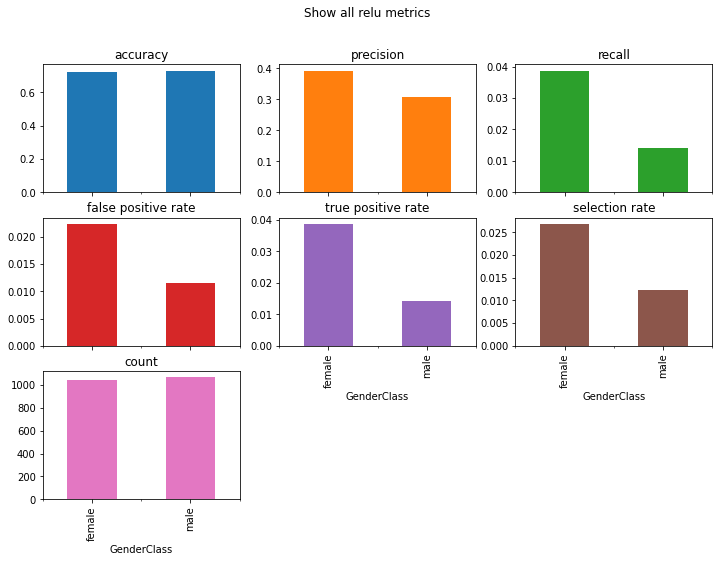

In [ ]:
# create ANN model https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/ 
### relu Activation function in all layers and sigmoid in output layer ###
model_relu = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model_relu.add(Dense(27, input_shape=(26,), kernel_initializer=initializer, bias_initializer="zeros", activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model_relu.add(Dense(units=5, kernel_initializer=initializer, bias_initializer="zeros", activation='relu'))
 
# The output neuron is a single fully connected node 
#
model_relu.add(Dense(1, kernel_initializer=initializer,activation='sigmoid'))
 
# Compiling the model
model_relu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Fitting the ANN to the Training set
model_relu.fit(X_train, y_train ,batch_size = 256, epochs = 30, verbose=1)

# Generating Predictions on testing data
Predictions_relu=model_relu.predict(X_test)

TestingData=pd.DataFrame(data=X_test.values, columns=PredictorVariables)
#TestingData.insert(len(df.columns), 'Churn', y_test.values)
#TestingData.assign(Churn=y_test)
TestingData["Churn"]=y_test
TestingData['PredictedChurnRelu']=Predictions_relu

#transform Predicted Churn from decimal to 0 or 1 for Confusion Matrix & insert into Fairlearn
TestingData["PredictedChurnReluClass"]= np.where(TestingData['PredictedChurnRelu']>=0.5, 1, 0)
#print(y_test[:10])
print(y_test.dtype)
print(TestingData.sample(11))
model_relu.evaluate(X_test, y_test)

#Fairlearn https://fairlearn.org/v0.7.0/quickstart.html
gm_relu = MetricFrame(metrics=accuracy_score, y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnReluClass'], sensitive_features=TestingData['gender'])
print("\n")
print("Model score: ")
print(gm_relu.overall)

print("\n" "Model score by category: ")
print(gm_relu.by_group)
print(' Remember, from data wrangling, IF [gender]="female" THEN "1" ELSE "0" ENDIF" \n')

#FairLearn Metrics
sr_relu = MetricFrame(metrics=selection_rate,y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnReluClass'], sensitive_features=TestingData['gender'])
sr_relu.overall
print("1.0==female, 0.0==male")
sr_relu.by_group
#transform Sensative Varible from 0 or 1 to "male" or "female" for plotting
TestingData["GenderClass"]= np.where(TestingData['gender']==1, "female","male")
#print(TestingData.head)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}
metric_frame_relu = MetricFrame(metrics=metrics,
                           y_true=TestingData['Churn'],
                           y_pred=TestingData['PredictedChurnReluClass'],
                           sensitive_features=TestingData["GenderClass"])
metric_frame_relu.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all relu metrics",
)


In [ ]:
print("\n X_test head: \n")
TestingData.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,PredictedChurnRelu,PredictedChurnReluClass,GenderClass
0,0.0,0.0,0.115423,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.495888,0,female
1,0.0,1.0,0.714428,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.484444,0,female
2,1.0,0.0,0.506965,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0,0.000756,0,female
3,0.0,1.0,0.612935,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0,0.001038,0,female
4,0.0,0.0,0.620896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.495888,0,female


## Tanh Activation Function

Hyperbolic tangent activation function.

https://keras.io/api/layers/activations/#tanh-function

Epoch 1/30
20/20 [==============================] - 1s 4ms/step - loss: 0.9475 - accuracy: 0.6164
Epoch 2/30
20/20 [==============================] - 0s 4ms/step - loss: 0.8556 - accuracy: 0.6499
Epoch 3/30
20/20 [==============================] - 0s 5ms/step - loss: 0.7881 - accuracy: 0.6682
Epoch 4/30
20/20 [==============================] - 0s 7ms/step - loss: 0.7369 - accuracy: 0.6816
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 0.6951 - accuracy: 0.6922
Epoch 6/30
20/20 [==============================] - 0s 6ms/step - loss: 0.6614 - accuracy: 0.7030
Epoch 7/30
20/20 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.7139
Epoch 8/30
20/20 [==============================] - 0s 5ms/step - loss: 0.6131 - accuracy: 0.7229
Epoch 9/30
20/20 [==============================] - 0s 7ms/step - loss: 0.5949 - accuracy: 0.7324
Epoch 10/30
20/20 [==============================] - 0s 7ms/step - loss: 0.5796 - accuracy: 0.7361
Epoch 11/30
20/20 [

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb11eb8c50>,
      dtype=object)

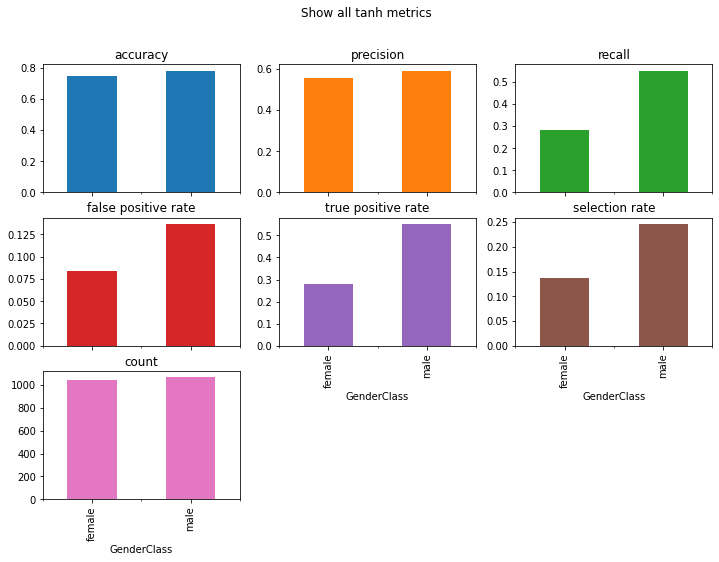

In [ ]:
# create ANN model https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/ 
### tanh Activation function in all layers and sigmoid in output layer ###
model_tanh = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model_tanh.add(Dense(27, input_shape=(26,), kernel_initializer=initializer, bias_initializer="zeros", activation='tanh'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model_tanh.add(Dense(units=5, kernel_initializer=initializer, bias_initializer="zeros",activation='tanh'))
 
# The output neuron is a single fully connected node 
#
model_tanh.add(Dense(1, kernel_initializer=initializer,activation='sigmoid'))
 
# Compiling the model
model_tanh.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Fitting the ANN to the Training set
model_tanh.fit(X_train, y_train ,batch_size = 256, epochs = 30, verbose=1)

# Generating Predictions on testing data
Predictions_tanh=model_tanh.predict(X_test)

#TestingData=pd.DataFrame(data=X_test.values, columns=PredictorVariables)
#TestingData['Churn']=y_test.values
TestingData['PredictedChurnTanh']=Predictions_tanh

#transform Predicted Churn from decimal to 0 or 1 for Confusion Matrix & insert into Fairlearn
TestingData["PredictedChurnTanhClass"]= np.where(TestingData['PredictedChurnTanh']>=0.5, 1, 0)
print(y_test.dtype)
print(TestingData.sample(11))
model_tanh.evaluate(X_test, y_test)

#Fairlearn https://fairlearn.org/v0.7.0/quickstart.html
gm_tanh = MetricFrame(metrics=accuracy_score, y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnTanhClass'], sensitive_features=TestingData['gender'])
print("\n")
print("Model score: ")
print(gm_tanh.overall)

print("\n" "Model score by category: ")
print(gm_tanh.by_group)
print(' Remember, from data wrangling, IF [gender]="female" THEN "1" ELSE "0" ENDIF" \n')

#FairLearn Metrics
sr_tanh = MetricFrame(metrics=selection_rate,y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnTanhClass'], sensitive_features=TestingData['gender'])
sr_tanh.overall
print("1.0==female, 0.0==male")
sr_tanh.by_group
#transform Sensative Varible from 0 or 1 to "male" or "female" for plotting
#TestingData["GenderClass"]= np.where(TestingData['gender']>=1, "female","male")
#print(TestingData.head)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}
metric_frame_tanh = MetricFrame(metrics=metrics,
                           y_true=TestingData['Churn'],
                           y_pred=TestingData['PredictedChurnTanhClass'],
                           sensitive_features=TestingData["GenderClass"])
metric_frame_tanh.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all tanh metrics",
)

In [ ]:
print("\n X_test head: \n")
TestingData.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,PredictedChurnRelu,PredictedChurnReluClass,GenderClass,PredictedChurnTanh,PredictedChurnTanhClass
0,0.0,0.0,0.115423,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0.495888,0,female,0.186722,0
1,0.0,1.0,0.714428,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0,0.484444,0,female,0.266957,0
2,1.0,0.0,0.506965,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0,0.000756,0,female,0.044898,0
3,0.0,1.0,0.612935,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0,0.001038,0,female,0.044454,0
4,0.0,0.0,0.620896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1,0.495888,0,female,0.356449,0


## Selu Activation Function

Scaled Exponential Linear Unit (SELU).

https://keras.io/api/layers/activations/#selu-function

Epoch 1/30
20/20 [==============================] - 1s 4ms/step - loss: 1.6997 - accuracy: 0.6274
Epoch 2/30
20/20 [==============================] - 0s 4ms/step - loss: 1.3510 - accuracy: 0.6402
Epoch 3/30
20/20 [==============================] - 0s 4ms/step - loss: 1.1406 - accuracy: 0.6589
Epoch 4/30
20/20 [==============================] - 0s 6ms/step - loss: 0.9944 - accuracy: 0.6914
Epoch 5/30
20/20 [==============================] - 0s 4ms/step - loss: 0.9074 - accuracy: 0.7091
Epoch 6/30
20/20 [==============================] - 0s 4ms/step - loss: 0.8519 - accuracy: 0.7164
Epoch 7/30
20/20 [==============================] - 0s 4ms/step - loss: 0.8074 - accuracy: 0.7158
Epoch 8/30
20/20 [==============================] - 0s 5ms/step - loss: 0.7691 - accuracy: 0.7180
Epoch 9/30
20/20 [==============================] - 0s 4ms/step - loss: 0.7376 - accuracy: 0.7265
Epoch 10/30
20/20 [==============================] - 0s 8ms/step - loss: 0.7062 - accuracy: 0.7288
Epoch 11/30
20/20 [

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb0f960210>,
      dtype=object)

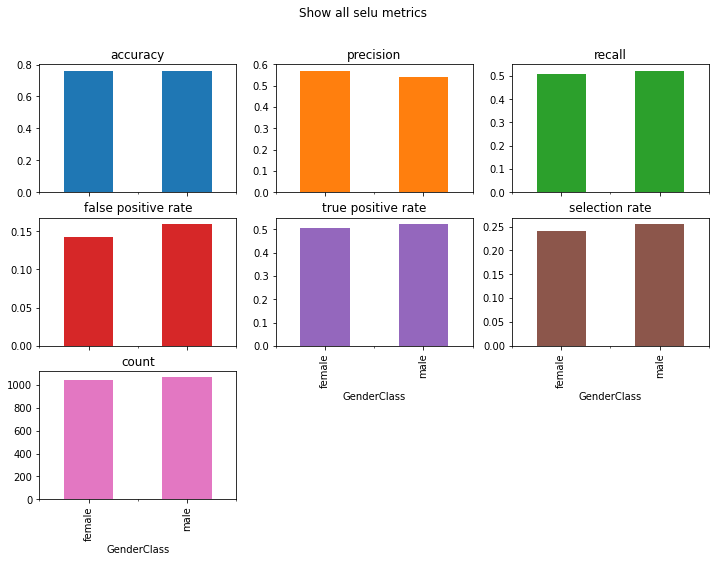

In [ ]:
# create ANN model https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/
### Selu Activation function in all layers and sigmoid in output layer ###
model_selu = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model_selu.add(Dense(27, input_shape=(26,), kernel_initializer=initializer, bias_initializer="zeros", activation='selu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model_selu.add(Dense(units=5, kernel_initializer=initializer, bias_initializer="zeros", activation='selu'))
 
# The output neuron is a single fully connected node 
#
model_selu.add(Dense(1, kernel_initializer=initializer,activation='sigmoid'))
 
# Compiling the model
model_selu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Fitting the ANN to the Training set
model_selu.fit(X_train, y_train ,batch_size = 256, epochs = 30, verbose=1)

# Generating Predictions on testing data
Predictions_selu=model_selu.predict(X_test)

#TestingData=pd.DataFrame(data=X_test.values, columns=PredictorVariables)
#TestingData['Churn']=y_test.values
TestingData['PredictedChurnSelu']=Predictions_selu

#transform Predicted Churn from decimal to 0 or 1 for Confusion Matrix & insert into Fairlearn
TestingData["PredictedChurnSeluClass"]= np.where(TestingData['PredictedChurnSelu']>=0.5, 1, 0)
print(y_test.dtype)
print(TestingData.sample(11))
model_selu.evaluate(X_test, y_test)

#Fairlearn https://fairlearn.org/v0.7.0/quickstart.html
gm_selu = MetricFrame(metrics=accuracy_score, y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnSeluClass'], sensitive_features=TestingData['gender'])
print("\n")
print("Model score: ")
print(gm_selu.overall)

print("\n" "Model score by category: ")
print(gm_selu.by_group)
print(' Remember, from data wrangling, IF [gender]="female" THEN "1" ELSE "0" ENDIF" \n')

#FairLearn Metrics
sr_selu = MetricFrame(metrics=selection_rate,y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnSeluClass'], sensitive_features=TestingData['gender'])
sr_selu.overall
print("1.0==female, 0.0==male")
sr_selu.by_group
#transform Sensative Varible from 0 or 1 to "male" or "female" for plotting
#TestingData["GenderClass"]= np.where(TestingData['gender']>=1, "female","male")
#print(TestingData.head)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}
metric_frame_selu = MetricFrame(metrics=metrics,
                           y_true=TestingData['Churn'],
                           y_pred=TestingData['PredictedChurnSeluClass'],
                           sensitive_features=TestingData["GenderClass"])
metric_frame_selu.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all selu metrics",
)

In [ ]:
print("\n X_test head: \n")
TestingData.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,PredictedChurnRelu,PredictedChurnReluClass,GenderClass,PredictedChurnTanh,PredictedChurnTanhClass,PredictedChurnSelu,PredictedChurnSeluClass
0,0.0,0.0,0.115423,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0,0.495888,0,female,0.186722,0,0.656103,1
1,0.0,1.0,0.714428,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0,0.484444,0,female,0.266957,0,0.734698,1
2,1.0,0.0,0.506965,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0,0.000756,0,female,0.044898,0,0.009437,0
3,0.0,1.0,0.612935,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0,0.001038,0,female,0.044454,0,0.003399,0
4,0.0,0.0,0.620896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1,0.495888,0,female,0.356449,0,0.813265,1


## Elu Activation Function

Exponential Linear Unit.

https://keras.io/api/layers/activations/#elu-function

Epoch 1/30
20/20 [==============================] - 1s 4ms/step - loss: 2.4125 - accuracy: 0.7156
Epoch 2/30
20/20 [==============================] - 0s 5ms/step - loss: 1.9519 - accuracy: 0.7172
Epoch 3/30
20/20 [==============================] - 0s 4ms/step - loss: 1.5841 - accuracy: 0.7152
Epoch 4/30
20/20 [==============================] - 0s 5ms/step - loss: 1.2949 - accuracy: 0.7148
Epoch 5/30
20/20 [==============================] - 0s 4ms/step - loss: 1.0752 - accuracy: 0.7152
Epoch 6/30
20/20 [==============================] - 0s 3ms/step - loss: 0.9119 - accuracy: 0.7143
Epoch 7/30
20/20 [==============================] - 0s 5ms/step - loss: 0.7952 - accuracy: 0.7145
Epoch 8/30
20/20 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.7178
Epoch 9/30
20/20 [==============================] - 0s 5ms/step - loss: 0.6471 - accuracy: 0.7206
Epoch 10/30
20/20 [==============================] - 0s 3ms/step - loss: 0.6035 - accuracy: 0.7235
Epoch 11/30
20/20 [

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb0ed70890>,
      dtype=object)

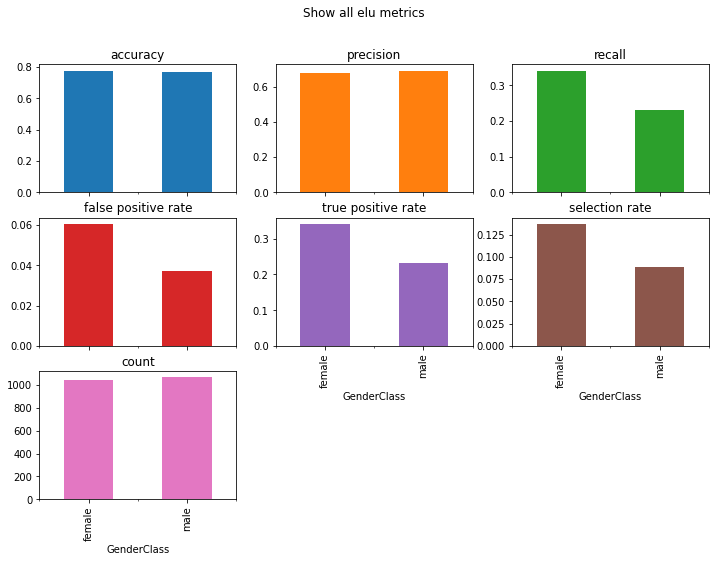

In [ ]:
# create ANN model https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/
### elu Activation function in all layers and sigmoid in output layer ###
model_elu = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model_elu.add(Dense(27, input_shape=(26,), kernel_initializer=initializer, bias_initializer="zeros", activation='elu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model_elu.add(Dense(units=5, kernel_initializer=initializer, bias_initializer="zeros", activation='elu'))
 
# The output neuron is a single fully connected node 
#
model_elu.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
 
# Compiling the model
model_elu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Fitting the ANN to the Training set
model_elu.fit(X_train, y_train ,batch_size = 256, epochs = 30, verbose=1)

# Generating Predictions on testing data
Predictions_elu=model_elu.predict(X_test)

#TestingData=pd.DataFrame(data=X_test.values, columns=PredictorVariables)
#TestingData['Churn']=y_test.values
TestingData['PredictedChurnElu']=Predictions_elu

#transform Predicted Churn from decimal to 0 or 1 for Confusion Matrix & insert into Fairlearn
TestingData["PredictedChurnEluClass"]= np.where(TestingData['PredictedChurnElu']>=0.5, 1, 0)
print(y_test.dtype)
print(TestingData.sample(11))
model_elu.evaluate(X_test, y_test)

#Fairlearn https://fairlearn.org/v0.7.0/quickstart.html
gm_elu = MetricFrame(metrics=accuracy_score, y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnEluClass'], sensitive_features=TestingData['gender'])
print("\n")
print("Model score: ")
print(gm_elu.overall)

print("\n" "Model score by category: ")
print(gm_elu.by_group)
print(' Remember, from data wrangling, IF [gender]="female" THEN "1" ELSE "0" ENDIF" \n')

#FairLearn Metrics
sr_elu = MetricFrame(metrics=selection_rate,y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnEluClass'], sensitive_features=TestingData['gender'])
sr_elu.overall
print("1.0==female, 0.0==male")
sr_elu.by_group
#transform Sensative Varible from 0 or 1 to "male" or "female" for plotting
#TestingData["GenderClass"]= np.where(TestingData['gender']>=1, "female","male")
#print(TestingData.head)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}
metric_frame_elu = MetricFrame(metrics=metrics,
                           y_true=TestingData['Churn'],
                           y_pred=TestingData['PredictedChurnEluClass'],
                           sensitive_features=TestingData["GenderClass"])
metric_frame_elu.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all elu metrics",
)

In [ ]:
print("\n X_test head: \n")
TestingData.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,Churn,PredictedChurnRelu,PredictedChurnReluClass,GenderClass,PredictedChurnTanh,PredictedChurnTanhClass,PredictedChurnSelu,PredictedChurnSeluClass,PredictedChurnElu,PredictedChurnEluClass
0,0.0,0.0,0.115423,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0.495888,0,female,0.186722,0,0.656103,1,0.461309,0
1,0.0,1.0,0.714428,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0.484444,0,female,0.266957,0,0.734698,1,0.460767,0
2,1.0,0.0,0.506965,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,0.000756,0,female,0.044898,0,0.009437,0,0.043969,0
3,0.0,1.0,0.612935,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,0.001038,0,female,0.044454,0,0.003399,0,0.027996,0
4,0.0,0.0,0.620896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1,0.495888,0,female,0.356449,0,0.813265,1,0.666731,1


## Exponential Activation Function

https://keras.io/api/layers/activations/#exponential-function

Epoch 1/30
20/20 [==============================] - 1s 3ms/step - loss: 116899752.0000 - accuracy: 0.2769
Epoch 2/30
20/20 [==============================] - 0s 3ms/step - loss: 39090000.0000 - accuracy: 0.2834
Epoch 3/30
20/20 [==============================] - 0s 3ms/step - loss: 23493776.0000 - accuracy: 0.2903
Epoch 4/30
20/20 [==============================] - 0s 2ms/step - loss: 15495523.0000 - accuracy: 0.2983
Epoch 5/30
20/20 [==============================] - 0s 2ms/step - loss: 11782044.0000 - accuracy: 0.3113
Epoch 6/30
20/20 [==============================] - 0s 3ms/step - loss: 9270788.0000 - accuracy: 0.3216
Epoch 7/30
20/20 [==============================] - 0s 2ms/step - loss: 7559385.0000 - accuracy: 0.3344
Epoch 8/30
20/20 [==============================] - 0s 2ms/step - loss: 6303822.0000 - accuracy: 0.3407
Epoch 9/30
20/20 [==============================] - 0s 2ms/step - loss: 5415619.0000 - accuracy: 0.3523
Epoch 10/30
20/20 [==============================] - 0s 2m

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb0c855b10>,
      dtype=object)

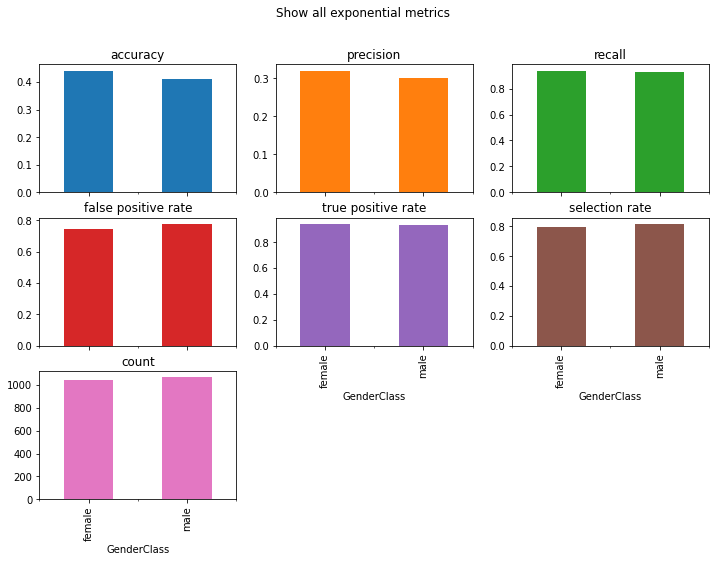

In [ ]:
# create ANN model https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/
### Sligtht variation from the rest...exponential Activation function in all layers did not work so relu is in first layer, exponential in hidden layer & sigmoid in output layer ###
model_exponential = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model_exponential.add(Dense(27, input_shape=(26,), kernel_initializer=initializer, bias_initializer="zeros", activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model_exponential.add(Dense(units=5, kernel_initializer=initializer, bias_initializer="zeros", activation='exponential'))
 
# The output neuron is a single fully connected node 
#
model_exponential.add(Dense(1, kernel_initializer=initializer,activation='sigmoid'))
 
# Compiling the model
model_exponential.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Fitting the ANN to the Training set
model_exponential.fit(X_train, y_train ,batch_size = 256, epochs = 30, verbose=1)

# Generating Predictions on testing data
Predictions_exponential=model_exponential.predict(X_test)

#TestingData=pd.DataFrame(data=X_test.values, columns=PredictorVariables)
#TestingData['Churn']=y_test.values
TestingData['PredictedChurnExponential']=Predictions_exponential

#transform Predicted Churn from decimal to 0 or 1 for Confusion Matrix & insert into Fairlearn
TestingData["PredictedChurnExponentialClass"]= np.where(TestingData['PredictedChurnExponential']>=0.5, 1, 0)
print(y_test.dtype)
print(TestingData.sample(11))
model_exponential.evaluate(X_test, y_test)

#Fairlearn https://fairlearn.org/v0.7.0/quickstart.html
gm_exponential = MetricFrame(metrics=accuracy_score, y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnExponentialClass'], sensitive_features=TestingData['gender'])
print("\n")
print("Model score: ")
print(gm_exponential.overall)

print("\n" "Model score by category: ")
print(gm_exponential.by_group)
print(' Remember, from data wrangling, IF [gender]="female" THEN "1" ELSE "0" ENDIF" \n')

#FairLearn Metrics
sr_exponential = MetricFrame(metrics=selection_rate,y_true=TestingData['Churn'], y_pred=TestingData['PredictedChurnExponentialClass'], sensitive_features=TestingData['gender'])
sr_exponential.overall
print("1.0==female, 0.0==male")
sr_exponential.by_group
#transform Sensative Varible from 0 or 1 to "male" or "female" for plotting
#TestingData["GenderClass"]= np.where(TestingData['gender']>=1, "female","male")
#print(TestingData.head)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}
metric_frame_exponential = MetricFrame(metrics=metrics,
                           y_true=TestingData['Churn'],
                           y_pred=TestingData['PredictedChurnExponentialClass'],
                           sensitive_features=TestingData["GenderClass"])
metric_frame_exponential.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all exponential metrics",
)

In [ ]:
print("\n X_test head: \n")
TestingData.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,PredictedChurnReluClass,GenderClass,PredictedChurnTanh,PredictedChurnTanhClass,PredictedChurnSelu,PredictedChurnSeluClass,PredictedChurnElu,PredictedChurnEluClass,PredictedChurnExponential,PredictedChurnExponentialClass
0,0.0,0.0,0.115423,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,female,0.186722,0,0.656103,1,0.461309,0,1.0,1
1,0.0,1.0,0.714428,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,female,0.266957,0,0.734698,1,0.460767,0,1.0,1
2,1.0,0.0,0.506965,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,female,0.044898,0,0.009437,0,0.043969,0,0.0,0
3,0.0,1.0,0.612935,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,female,0.044454,0,0.003399,0,0.027996,0,1.0,1
4,0.0,0.0,0.620896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,female,0.356449,0,0.813265,1,0.666731,1,1.0,1


# Fairlearn Metrics

## Overall Model Metrics

In [ ]:
print ("Relu\n", metric_frame_relu.overall, 
      "\n\nTanh\n", metric_frame_tanh.overall,
      "\n\nSelu\n", metric_frame_selu.overall,
      "\n\nElu\n", metric_frame_elu.overall,
      "\n\nExponential\n", metric_frame_exponential.overall,
      "\n")


Relu
 accuracy               0.727014
precision              0.365854
recall                 0.026549
false positive rate    0.016828
true positive rate     0.026549
selection rate         0.019431
count                      2110
dtype: object 

Tanh
 accuracy               0.762559
precision              0.578818
recall                 0.415929
false positive rate     0.11068
true positive rate     0.415929
selection rate         0.192417
count                      2110
dtype: object 

Selu
 accuracy               0.759716
precision              0.555344
recall                 0.515044
false positive rate    0.150809
true positive rate     0.515044
selection rate         0.248341
count                      2110
dtype: object 

Elu
 accuracy                0.77346
precision              0.683544
recall                 0.286726
false positive rate    0.048544
true positive rate     0.286726
selection rate         0.112322
count                      2110
dtype: object 

Exponential
 accu

## By Group Metrics

In [ ]:
print("Relu       =", metric_frame_relu.by_group.to_dict(),"\n")
#print("Sigmoid    =", metric_frame_sigmoid.by_group.to_dict(),"\n")
#print("Softmax    =", metric_frame_softmax.by_group.to_dict(),"\n")
#print("Softplus   =", metric_frame_softplus.by_group.to_dict(),"\n")
#print("Softsign   =", metric_frame_softsign.by_group.to_dict(),"\n")
print("Tanh       =", metric_frame_tanh.by_group.to_dict(),"\n")
print("Selu       =", metric_frame_selu.by_group.to_dict(),"\n")
print("Elu        =", metric_frame_elu.by_group.to_dict(),"\n")
print("Exponential=", metric_frame_exponential.by_group.to_dict(),"\n")

Relu       = {'accuracy': {'female': 0.722488038277512, 'male': 0.7314553990610329}, 'precision': {'female': 0.39285714285714285, 'male': 0.3076923076923077}, 'recall': {'female': 0.03873239436619718, 'male': 0.014234875444839857}, 'false positive rate': {'female': 0.022339027595269383, 'male': 0.011479591836734694}, 'true positive rate': {'female': 0.03873239436619718, 'male': 0.014234875444839857}, 'selection rate': {'female': 0.026794258373205742, 'male': 0.012206572769953052}, 'count': {'female': 1045, 'male': 1065}} 

Tanh       = {'accuracy': {'female': 0.7435406698564593, 'male': 0.7812206572769953}, 'precision': {'female': 0.5555555555555556, 'male': 0.5916030534351145}, 'recall': {'female': 0.28169014084507044, 'male': 0.5516014234875445}, 'false positive rate': {'female': 0.08409986859395532, 'male': 0.1364795918367347}, 'true positive rate': {'female': 0.28169014084507044, 'male': 0.5516014234875445}, 'selection rate': {'female': 0.13779904306220095, 'male': 0.24600938967136

In [ ]:
print("\n X_test head: \n")
TestingData.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,PredictedChurnReluClass,GenderClass,PredictedChurnTanh,PredictedChurnTanhClass,PredictedChurnSelu,PredictedChurnSeluClass,PredictedChurnElu,PredictedChurnEluClass,PredictedChurnExponential,PredictedChurnExponentialClass
0,0.0,0.0,0.115423,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,female,0.186722,0,0.656103,1,0.461309,0,1.0,1
1,0.0,1.0,0.714428,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,female,0.266957,0,0.734698,1,0.460767,0,1.0,1
2,1.0,0.0,0.506965,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,female,0.044898,0,0.009437,0,0.043969,0,0.0,0
3,0.0,1.0,0.612935,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,female,0.044454,0,0.003399,0,0.027996,0,1.0,1
4,0.0,0.0,0.620896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,female,0.356449,0,0.813265,1,0.666731,1,1.0,1


# Gender variable DoubleCheck
Compare to make sure Gender Variable is properly identified.  The count should mat counted.

In [ ]:
rp.summary_cont(TestingData["gender"])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,gender,2110.0,0.4953,0.5001,0.0109,0.4739,0.5166


In [ ]:
rp.summary_cat(TestingData["gender"])

,Variable,Outcome,Count,Percent
0,gender,0.0,1065,50.47
1,,1.0,1045,49.53


In [ ]:
print("\n X_test head: \n")
TestingData.head()


 X_test head: 



,Dependents,DeviceProtection,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PhoneService,SeniorCitizen,...,PredictedChurnReluClass,GenderClass,PredictedChurnTanh,PredictedChurnTanhClass,PredictedChurnSelu,PredictedChurnSeluClass,PredictedChurnElu,PredictedChurnEluClass,PredictedChurnExponential,PredictedChurnExponentialClass
0,0.0,0.0,0.115423,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,female,0.186722,0,0.656103,1,0.461309,0,1.0,1
1,0.0,1.0,0.714428,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,female,0.266957,0,0.734698,1,0.460767,0,1.0,1
2,1.0,0.0,0.506965,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,female,0.044898,0,0.009437,0,0.043969,0,0.0,0
3,0.0,1.0,0.612935,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,female,0.044454,0,0.003399,0,0.027996,0,1.0,1
4,0.0,0.0,0.620896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,female,0.356449,0,0.813265,1,0.666731,1,1.0,1
